In [12]:
import os 
import sys 
from contextlib import contextmanager
from time import time

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import lightgbm as lgbm

In [13]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    """時間を測るやつ"""
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)
from tqdm import tqdm


def get_function(block, is_train):
    s = mapping = {
        True: 'fit',
        False: 'transform'
    }.get(is_train)
    return getattr(block, s)


def to_feature(input_df, 
               blocks,
               is_train=False):
    out_df = pd.DataFrame()

    for block in tqdm(blocks, total=len(blocks)):
        func = get_function(block, is_train)

        with timer(prefix='create ' + str(block) + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [14]:
INPUT_DIR = '/Users/mei/Documents/skill_up/kickstarter/input'
OUTPUT_DIR = '/Users/mei/Documents/skill_up/kickstarter/output'

# df_2016 = pd.read_csv(os.path.join(INPUT_DIR,'ks-projects-201612.csv'))
df_2018 = pd.read_csv(os.path.join(INPUT_DIR,'ks-projects-201801.csv'))

TARGET = 'state'
y = df_2018[TARGET]
del df_2018[TARGET]
X = df_2018.copy() 

# 訓練データ，テストデータに分ける
train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.2,random_state=42, stratify=y)

train_df = pd.concat([train_X,train_y],axis=1).reset_index(drop=True)
test_df = pd.concat([test_X,test_y],axis=1).reset_index(drop=True)
whole_df = pd.concat([train_df,test_df]).reset_index(drop=True)

In [15]:
def mapping(x):
    if x == 'failed':
        return 0
    elif x == 'canceled':
        return 1
    elif x == 'successful':
        return 2
    elif x=='live':
        return 3
    elif x=='undefined':
        return 4
    elif x=='suspended':
        return 5
    else:
        raise Exception
def encode_label(train_y, test_y):
    # 正解ラベルをエンコーディングしていく
    n_train = len(train_y)
    df = pd.concat([train_y,test_y]).reset_index(drop=True)
    
    df = df.apply(lambda x:mapping(x))


    test_y = df.iloc[n_train:].reset_index(drop=True)
    train_y = df.iloc[:n_train].reset_index(drop=True)

    return train_y,test_y

train_y,test_y = encode_label(train_y.copy(),test_y.copy())


In [16]:
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        raise NotImplementedError()
    
class WrapperBlock(BaseBlock):
    def __init__(self, function):
        self.function = function

    def transform(self, input_df):
        return self.function(input_df)


# 前処理

In [17]:
# log1p変換を事前に行う

cols = ['goal','backers','pledged','usd_pledged_real','usd_goal_real']

for c in cols:
    train_df[c] = train_df[c].apply(lambda x: np.log1p(x))
    test_df[c] = test_df[c].apply(lambda x: np.log1p(x))


# 特徴量エンジニアリング

In [18]:
# def preprocess(input_df: pd.DataFrame)->pd.DataFrame:
#     output_df = pd.DataFrame()
#     cols = input_df.columns
#     for c in cols:
#         output_df[c] = input_df[c].apply(lambda x: np.log1p(x))
#     return output_df

# def create_continuous_feature(input_df:pd.DataFrame)->pd.DataFrame:
#     use_cols = ['goal','backers','pledged','usd_pledged_real','usd_goal_real']
#     output_df = preprocess(input_df[use_cols])
#     return output_df

def create_continuous_feature(input_df:pd.DataFrame)->pd.DataFrame:
    use_cols = ['goal','backers','pledged','usd_pledged_real','usd_goal_real']
    return input_df[use_cols].copy()

In [19]:
class CountEncoding(BaseBlock):
    #　カウントエンコーディングでカテゴリ変数を変換する
    def __init__(self,col,whole_df:pd.DataFrame):
        self.col = col
        self.whole_df = whole_df
    def transform(self, input_df:pd.DataFrame)-> pd.DataFrame:
        output_df = pd.DataFrame()
        c = self.col

        vc = self.whole_df[c].value_counts()
        output_df[c] = input_df[c].map(vc)
        return output_df.add_prefix('CE=')

class AggregationBlock(BaseBlock):
    # カテゴリ変数でグループ化した後集計する
    def __init__(self,group_col,target_col,whole_df:pd.DataFrame)-> pd.DataFrame:
        self.group_col = group_col
        self.target_col = target_col
        self.whole_df = whole_df
    
    def transform(self,input_df:pd.DataFrame)->pd.DataFrame:
        output_df = pd.DataFrame()
        col_name = str(f'{self.group_col}_{self.target_col}')
        _agg = whole_df.groupby(self.group_col)[self.target_col].agg(['count','sum','mean','max','min']).reset_index()
        output_df = pd.merge(input_df[self.group_col],_agg,on=self.group_col,how='left').reset_index(drop=True).drop(columns=self.group_col).add_prefix(col_name)
        return output_df.add_prefix(f'AG=')

In [24]:
# テスト
# assert len(Log1pBlock('goal').fit(train_df.copy())) == len(train_df)
# assert len(CountEncoding('country',whole_df).fit(train_df.copy())) == len(train_df)
# assert len(AggregationBlock('country','goal',whole_df)).fit(train_df.copy())==len(train_df)

In [25]:
from itertools import product

# パイプライン
process_block = [
    WrapperBlock(create_continuous_feature),
    *[CountEncoding(c,whole_df) for c in ['category','main_category','currency','country']],
    *[AggregationBlock(g,t,whole_df) for g,t in product(['category','main_category','currency','country'],['goal','pledged','backers','usd_pledged_real','usd_goal_real'])],
]
process_block

In [26]:
train_feat_df = to_feature(train_df.copy(),process_block,is_train=True)
test_feat_df = to_feature(test_df.copy(),process_block,is_train=False)

  8%|▊         | 2/25 [00:00<00:01, 16.93it/s]create <__main__.WrapperBlock object at 0x121dc59d0> 0.032[s]
create <__main__.CountEncoding object at 0x121dc5ca0> 0.080[s]
create <__main__.CountEncoding object at 0x121dc5e20> 0.073[s]
 16%|█▌        | 4/25 [00:00<00:01, 15.40it/s]create <__main__.CountEncoding object at 0x121dc5df0> 0.068[s]
create <__main__.CountEncoding object at 0x121dc58e0> 0.074[s]
create <__main__.AggregationBlock object at 0x121dc55b0> 0.089[s]
 28%|██▊       | 7/25 [00:00<00:01, 10.53it/s]create <__main__.AggregationBlock object at 0x121dc5fd0> 0.091[s]
create <__main__.AggregationBlock object at 0x121dc5340> 0.112[s]
 36%|███▌      | 9/25 [00:00<00:02,  7.18it/s]create <__main__.AggregationBlock object at 0x121dc5d30> 0.095[s]
create <__main__.AggregationBlock object at 0x121dc5970> 0.105[s]
 56%|█████▌    | 14/25 [00:02<00:02,  3.88it/s]create <__main__.AggregationBlock object at 0x121dc56d0> 0.136[s]
create <__main__.AggregationBlock object at 0x121dc5430> 0.

In [27]:
train_feat_df.head().T

,0,1,2,3,4
goal,7.313887e+00,9.210440e+00,7.601402e+00,1.046313e+01,7.824446e+00
backers,3.433987e+00,0.000000e+00,6.410175e+00,0.000000e+00,4.553877e+00
pledged,7.887584e+00,0.000000e+00,9.899605e+00,0.000000e+00,8.146419e+00
usd_pledged_real,7.887584e+00,0.000000e+00,9.899605e+00,0.000000e+00,7.860359e+00
usd_goal_real,7.313887e+00,9.210440e+00,7.601402e+00,1.092780e+01,7.538420e+00
...,...,...,...,...,...
AG=country_usd_goal_realcount,2.926270e+05,2.926270e+05,2.926270e+05,3.367200e+04,1.475600e+04
AG=country_usd_goal_realsum,1.288582e+10,1.288582e+10,1.288582e+10,1.440290e+09,6.552910e+08
AG=country_usd_goal_realmean,4.403497e+04,4.403497e+04,4.403497e+04,4.277412e+04,4.440844e+04
AG=country_usd_goal_realmax,1.000000e+08,1.000000e+08,1.000000e+08,1.663614e+08,8.262414e+07


In [28]:
def fit_lgbm(X,y,cv,params=None,verbose=50):
    ## lgbmの学習を行う
    if params is None:
        params = {}
    
    n_classes = len(np.unique(y))
    oof = np.zeros(shape=(len(y),n_classes),dtype=np.float)
    models = []

    for i, (idx_train, idx_valid) in enumerate(cv): 
        X_tr, y_tr = X[idx_train], y[idx_train]
        X_val, y_val = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params)
        clf.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=verbose)
        pred_i = clf.predict_proba(X_val)
        oof[idx_valid] = pred_i
        models.append(clf)

        return oof, models


In [29]:
params = {
    'n_estimators':1000,
    'learning_rate':.1,
    'reg_lambda': .1,
    'colsample_bytree': .5,
    'max_depth': 3,
    'min_child_weight': 10,
    'importance_type': 'gain'
}

In [30]:
from sklearn.model_selection import KFold
fold = KFold(n_splits=5, shuffle=True, random_state=42)
cv = list(fold.split(train_feat_df,train_y))
oof, models = fit_lgbm(train_feat_df.values,train_y.values,cv,verbose=10)

Training until validation scores don't improve for 100 rounds
[10]	valid_0's multi_logloss: 0.483118
[20]	valid_0's multi_logloss: 0.394171
[30]	valid_0's multi_logloss: 0.368548
[40]	valid_0's multi_logloss: 0.35838
[50]	valid_0's multi_logloss: 0.354151
[60]	valid_0's multi_logloss: 0.352361
[70]	valid_0's multi_logloss: 0.350847
[80]	valid_0's multi_logloss: 0.351476
[90]	valid_0's multi_logloss: 0.351203
[100]	valid_0's multi_logloss: 0.351133
Did not meet early stopping. Best iteration is:
[71]	valid_0's multi_logloss: 0.350776


In [31]:
print('train accuracy(oof):')
print(accuracy_score(train_y.values, np.argmax(oof,axis=1)))

y_pred = [model.predict_proba(train_feat_df.values) for model in models]
y_pred = np.array(y_pred)
y_pred = np.mean(y_pred,axis=0)
y_pred = np.argmax(y_pred,axis=1)
print('train accuracy:')
print(accuracy_score(train_y.values,y_pred))

train accuracy(oof):
0.5944646912797761
train accuracy:
0.8844378862303914


In [32]:
def visualize_importance(models, feat_train_df):
    # 重要特徴量の可視化
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(12, max(4, len(order) * .2)))
    sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance', order=order, ax=ax, palette='viridis')
    fig.tight_layout()
    ax.grid()
    return fig, ax

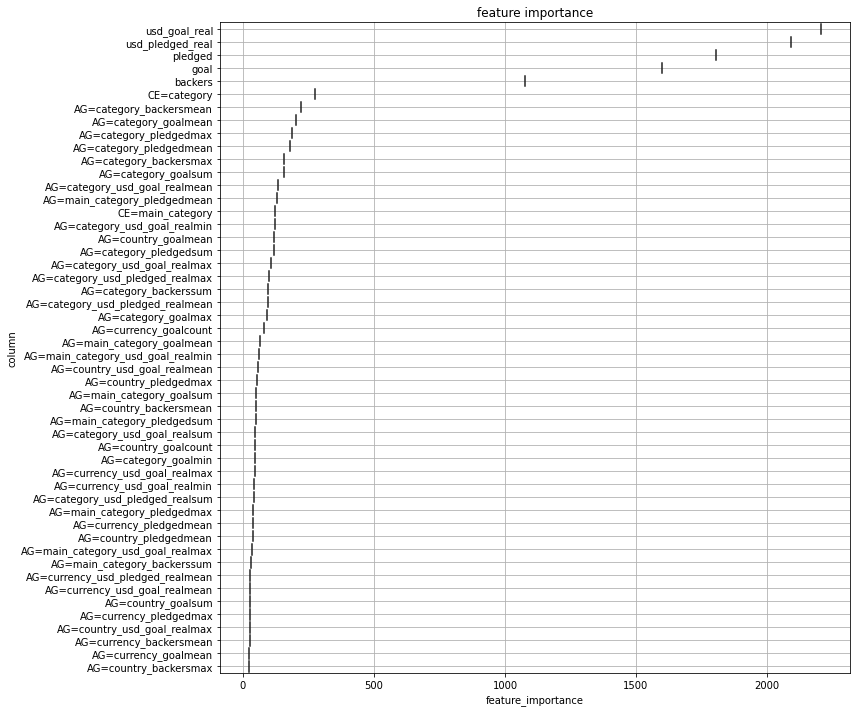

In [33]:
fig, ax = visualize_importance(models, train_feat_df)
ax.set_title('feature importance')
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, 'importance.png'), dpi=120)

In [34]:
y_pred = [model.predict_proba(test_feat_df.values) for model in models]
y_pred = np.array(y_pred)
y_pred = np.mean(y_pred,axis=0)
y_pred = np.argmax(y_pred,axis=1)
print('test accuracy:')
print(accuracy_score(test_y.values, y_pred))

test accuracy:
0.8824026514201206


## 結果

- データセットを8:2で訓練データとテストデータに分ける
- 訓練データを5分割の交差検証を行い学習していく．
- 5つのモデルの出力の平均から他クラス分類を行なった．

||accuracy|
|---|---|
|train|0.884|
|test|0.882|

今回作成したモデルでは，accuracy 0.88程度のモデルが作成できた．

# ハイパーパラメータチューニングをしていく

In [35]:
from optuna import Trial, create_study

def get_boosting_parameter_suggestions(trial: Trial) -> dict:
    """
    Get parameter sample for Boosting (like XGBoost, LightGBM)

    Args:
        trial(trial.Trial):

    Returns:
        dict: 
            parameter sample generated by trial object
    """
    return {
        # L2 正則化
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 1e3),

        # L1 正則化
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 1e3),

        # 弱学習木ごとに使う特徴量の割合
        # 0.5 だと全体のうち半分の特徴量を最初に選んで, その範囲内で木を成長させる
        'feature_fraction': trial.suggest_loguniform('feature_fraction', .5, 1.),

        # 学習データ全体のうち使用する割合
        # colsample とは反対に row 方向にサンプルする
        'bagging_fraction': trial.suggest_loguniform('bagging_fraction', .5, 1.),

        # 木の最大の深さ
        # たとえば 5 の時各弱学習木のぶん機は最大でも5に制限される.
        'max_depth': trial.suggest_int('max_depth', low=3, high=8),

        # 末端ノードに含まれる最小のサンプル数
        # これを下回るような分割は作れなくなるため, 大きく設定するとより全体の傾向でしか分割ができなくなる
        # [NOTE]: 数であるのでデータセットの大きさ依存であることに注意
        'min_child_weight': trial.suggest_uniform('min_child_weight', low=.5, high=40)
    }

In [36]:
def to_lgbm_params(params: dict) -> params:
    retval = dict(**params)
    retval.update({
        'n_estimators': 10000,
        'learning_rate': .1,
        'bagging_freq': 3,
        'importance_type': 'gain'
    })
    return retval

In [46]:
def objective(trial: Trial) -> float:
    """目的関数. 
    Trial instance をうけとって, その trial で作ったパラメータの評価値 (objective) の値を返します. """
    params = get_boosting_parameter_suggestions(trial)

    # 実際に lightGBM にわたす parameter に変換. 
    # この method を切り出しているのはあとで best trial の parameter 使って学習するときにもこの変換を使うため. 
    params = to_lgbm_params(params)

    # 今はすべての fold での検証結果で Out-of-fold score の見積もりをしているけれど、それなりに時間がかかる場合には
    # 一番はじめの fold だけでスコアを出す場合もある
    # 当然分散もあるため評価は不正確になる, この辺は時間とのトレードオフ
    oof, _ = fit_lgbm(train_feat_df.values, y, cv,params=params, verbose=None)

    score = accuracy_score(y, np.argmax(oof,axis=1))
    return score

In [47]:
study = create_study()
study.optimize(objective, 
               n_trials=1) 

[I 2020-12-17 00:56:46,826] A new study created in memory with name: no-name-3f86c945-c48b-4733-b119-745d4e16b632
[LightGBM] [Warning] bagging_fraction is set=0.7469290841295517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7469290841295517
[LightGBM] [Warning] feature_fraction is set=0.5528724304768599, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5528724304768599
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[I 2020-12-17 00:57:02,598] Trial 0 finished with value: 0.0 and parameters: {'reg_lambda': 0.001125764788401207, 'reg_alpha': 0.01895316002063856, 'feature_fraction': 0.5528724304768599, 'bagging_fraction': 0.7469290841295517, 'max_depth': 4, 'min_child_weight': 3.4764323853434287}. Best is trial 0 with value: 0.0.


In [48]:
study.best_params

{'reg_lambda': 0.001125764788401207,
 'reg_alpha': 0.01895316002063856,
 'feature_fraction': 0.5528724304768599,
 'bagging_fraction': 0.7469290841295517,
 'max_depth': 4,
 'min_child_weight': 3.4764323853434287}

In [49]:
oof, models = fit_lgbm(train_feat_df.values,train_y.values,cv,params=to_lgbm_params(study.best_params),verbose=10)

[LightGBM] [Warning] bagging_fraction is set=0.7469290841295517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7469290841295517
[LightGBM] [Warning] feature_fraction is set=0.5528724304768599, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5528724304768599
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Training until validation scores don't improve for 100 rounds
[10]	valid_0's multi_logloss: 0.535788
[20]	valid_0's multi_logloss: 0.446644
[30]	valid_0's multi_logloss: 0.410003
[40]	valid_0's multi_logloss: 0.392472
[50]	valid_0's multi_logloss: 0.381279
[60]	valid_0's multi_logloss: 0.373642
[70]	valid_0's multi_logloss: 0.367807
[80]	valid_0's multi_logloss: 0.364252
[90]	valid_0's multi_logloss: 0.361255
[100]	valid_0's multi_logloss: 0.359387
[110]	valid_0's multi_logloss: 0.358085
[120]	valid_0's multi_logloss: 0.35658
[130]	valid_0's multi_logloss: 0.355294
[140]	valid_0's mul

In [51]:
print('train accuracy(oof):')
print(accuracy_score(train_y.values, np.argmax(oof,axis=1)))

y_pred = [model.predict_proba(train_feat_df.values) for model in models]
y_pred = np.array(y_pred)
y_pred = np.mean(y_pred,axis=0)
y_pred = np.argmax(y_pred,axis=1)
print('train accuracy:')
print(accuracy_score(train_y.values,y_pred))

train accuracy(oof):
0.5946000369724819
train accuracy:
0.8849660645433899


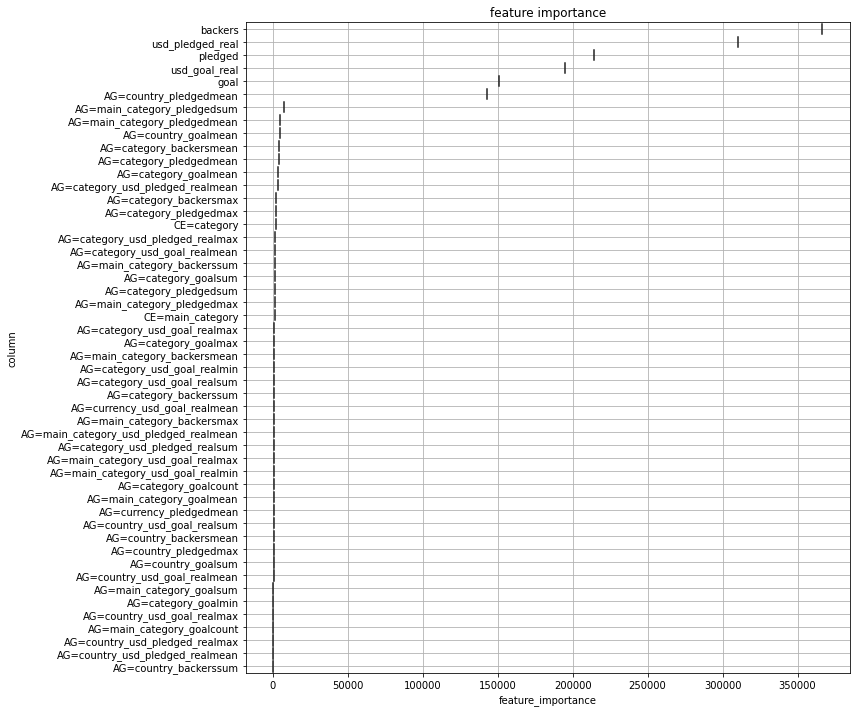

In [50]:
fig, ax = visualize_importance(models, train_feat_df)
ax.set_title('feature importance')
fig.tight_layout()

In [53]:
y_pred = [model.predict_proba(test_feat_df.values) for model in models]
y_pred = np.array(y_pred)
y_pred = np.mean(y_pred,axis=0)
y_pred = np.argmax(y_pred,axis=1)
print('test accuracy:')
print(accuracy_score(test_y.values, y_pred))

test accuracy:
0.8829176184754335


## 結果

- データセットを8:2で訓練データとテストデータに分ける
- 訓練データを5分割の交差検証を行い学習していく．
- 5つのモデルの出力の平均から他クラス分類を行なった．

||accuracy|
|---|---|
|train|0.884|
|test|0.882|

今回作成したモデルでは，accuracy 0.88程度のモデルが作成できた．

lgbm_1 にハイパーパラメータチューニングを行なったが，精度としては違いがなかった．

特徴量重要度の図を見ると，backers, use_pledged_real, pledged, usd_goal_real, goalの特徴量が重要視され，それ以外は重要でないことがわかる．
